In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [4]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [5]:
datasheet = datasheet.drop([
    'vendor_id', 
    'VAP', 
    'country', 
    'pet_size'
], axis=1)
datasheet.head()

,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,Equipment,123,7293,fish,7,1
4567,Toys,61,9304,cat,10,0
4237,Toys,218,8180,hamster,6,0
4364,Snack,69,18559,dog,1,1
4184,Supplements,138,10283,dog,10,0


### Plotting for analysis

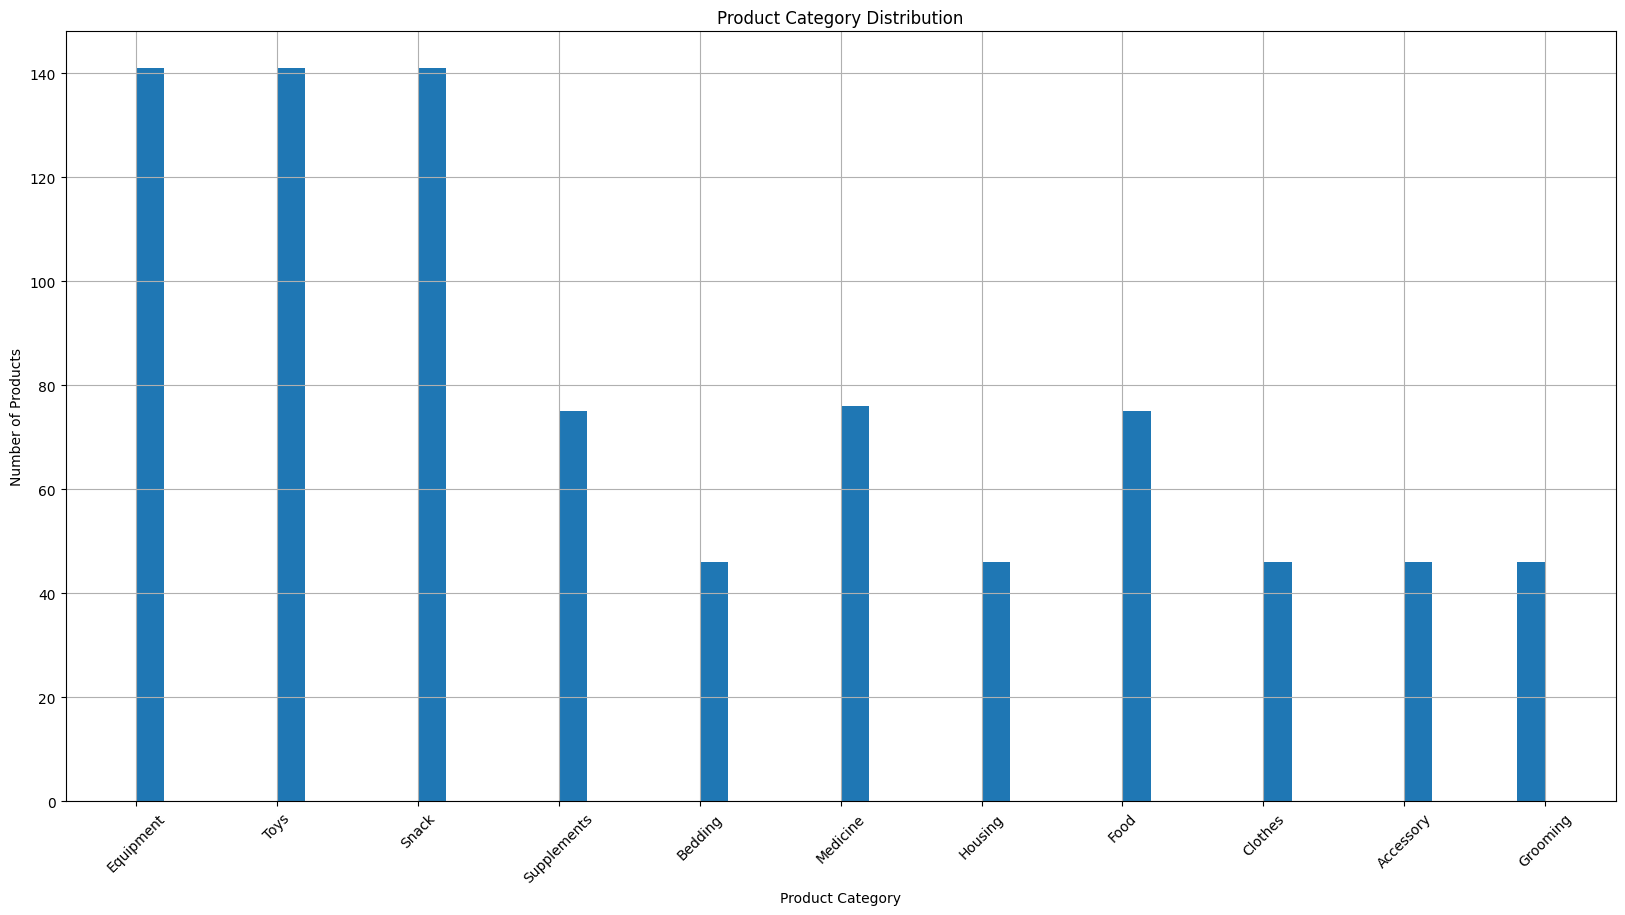

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

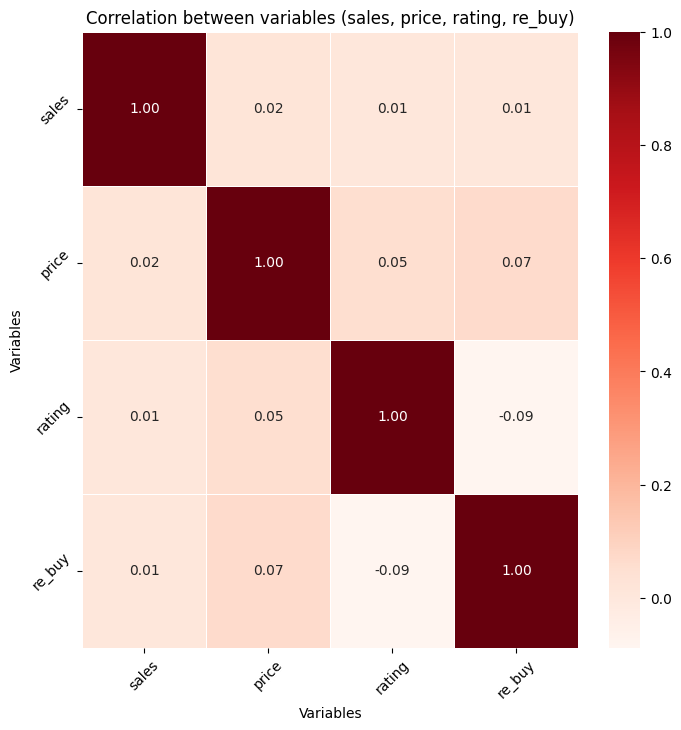

In [7]:
relationship = datasheet[["sales", "price", "rating", "re_buy"]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(relationship, annot=True, fmt=".2f", linewidths=.5, cmap='Reds')
plt.title("Correlation between variables (sales, price, rating, re_buy)")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.yticks([0.5, 1.5, 2.5, 3.5], ["sales", "price", "rating", "re_buy"], rotation=45)
plt.show()

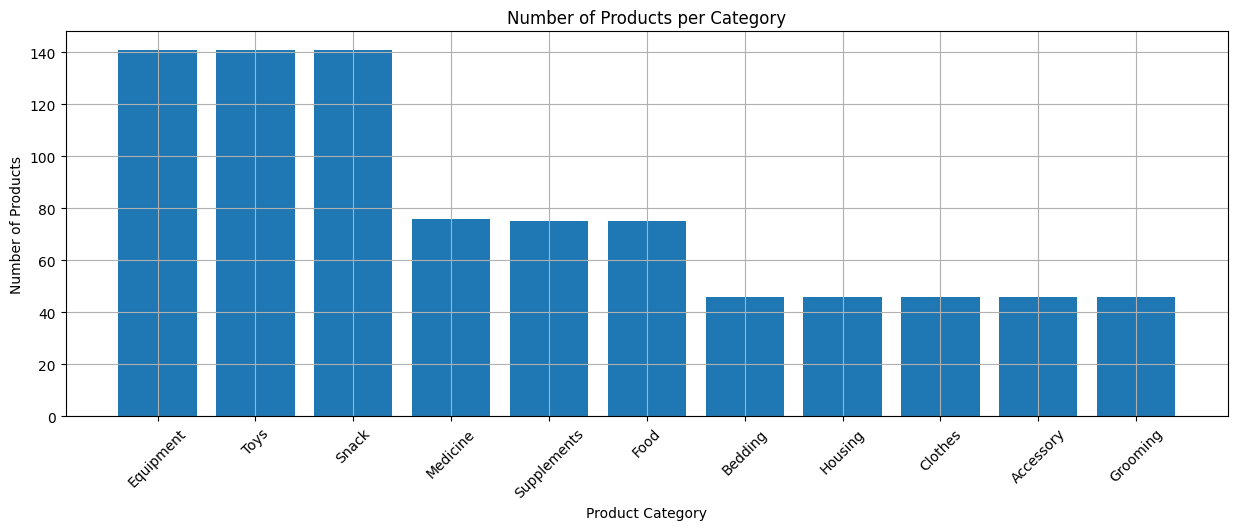

In [8]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

In [9]:
datasheet.head()

,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,Equipment,123,7293,fish,7,1
4567,Toys,61,9304,cat,10,0
4237,Toys,218,8180,hamster,6,0
4364,Snack,69,18559,dog,1,1
4184,Supplements,138,10283,dog,10,0


# Pre-processing

In [10]:
onehot_encoder = OneHotEncoder()

In [11]:
transformed_target = datasheet['pet_type'].values.reshape(-1, 1)
transformed_target_unique = np.unique(transformed_target)

le = LabelEncoder()
transformed_target = le.fit_transform(transformed_target.ravel())

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"le_name_mapping: {le_name_mapping}")

datasheet['pet_type'] = transformed_target

le_name_mapping: {'bird': 0, 'cat': 1, 'dog': 2, 'fish': 3, 'hamster': 4, 'rabbit': 5}


In [12]:
le = LabelEncoder()
product_category = datasheet['product_category'].to_numpy()
product_category_onehot = le.fit_transform(product_category.reshape(-1, 1)).astype(int)

print(f"One-hot encoded product category: {product_category_onehot}")

# softmax_dim = product_category_onehot.shape[1]
# print(f"Softmax dimension: {softmax_dim}")

One-hot encoded product category: [ 3 10 10  8  9  1 10  1  9  7  8  9  6  4  9  3  8  3  4  4  6  2  0  4
  7  3  0  4  6  9  7  3  8  2  8  7  0 10  1  3  8  1  0  4  4  8  5  8
 10  3  5  2  2  4  3 10  3 10  2  8  3  6  2  3  3  6  9  6  7  9  6 10
  5  1  5  0 10  7  3 10  4  0 10  6  8  9  9  1  2  3  6  8  5  8  9  2
  7  2  3 10 10  0  3  3 10 10  7  9  4 10  3  3  2  8  1  2  7  3  0  4
  6  4  7  8  3  8  3 10  8  7  4  3  7  5  8  8 10  8  7  4  6  3  8 10
 10  5 10  8 10  6 10  8  2  5  9  8  8  1  3  3  5  7  7  6 10 10  7  8
 10  3  8  8  8 10 10  3  4  3  8  9  2  9  3  8  8  7  9  2 10  7  4  8
  5  0  9  4  7 10  2  9 10  3 10  5 10  3  8 10 10  8 10 10  6  5  9  5
  2  7  2  8  1 10  0  3  5  7  8  9  3  1  9  3  9  7  3  0  3  1  4  3
  8  6  4  8 10  4  8 10  3  0  4  8  9  6  5  8  3  8 10  4 10 10  3  3
  3  8  4  7  7  4  3  1 10  2  3 10  8  9 10  3  8  0 10  8  3  9  7  5
  0  8  6  9  0  7  8  4 10  8  9  2  7  6  8  9  0  5  3 10  2  1  9  4
 10  7  0  9  1  

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
for i in range(len(datasheet.index)): datasheet['product_category'].iloc[i] = product_category_onehot[i]
datasheet.head(10)

/var/folders/gq/xnxpqv5x7jz19nnym4s4_l940000gn/T/ipykernel_52736/1629457035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i in range(len(datasheet.index)): datasheet['product_category'].iloc[i] = product_category_onehot[i]


,product_category,sales,price,pet_type,rating,re_buy
product_id,,,,,,
5040,3,123,7293,3,7,1
4567,10,61,9304,1,10,0
4237,10,218,8180,4,6,0
4364,8,69,18559,2,1,1
4184,9,138,10283,2,10,0
4609,1,183,3969,1,10,0
4380,10,79,13519,2,8,0
4389,1,205,13078,1,9,0
4697,9,116,13701,1,10,0


# Train, Test(Validation) Split

In [14]:
target = "product_category"

In [15]:
y_data = datasheet[target].to_numpy().astype(np.float32)
y_data = onehot_encoder.fit_transform(y_data.reshape(-1, 1)).toarray().astype(np.float32)
X_data = datasheet.drop([target], axis=1).to_numpy().astype(np.float32)

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 5)
y_data shape: (879, 11)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, shuffle=True)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (703, 5)
y_train: (703, 11)
X_test: (176, 5)
y_test: (176, 11)


# Datasets & DataLoader

In [17]:
BATCH_SIZE = 16

In [18]:
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        X = self.X_data[index].astype(np.float32)
        y = self.y_data[index].astype(np.float32)
        return X, y

    def __len__(self):
        return len(self.X_data)

In [19]:
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [20]:
device = torch.device('mps')

In [21]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.in_fc = nn.Linear(5, 64)

        self.hidden_1 = nn.Linear(64, 128)
        self.hidden_2 = nn.Linear(128, 64)

        self.out_fc = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.in_fc(x)
        x = F.gelu(x)

        x = self.hidden_1(x)
        x = F.gelu(x)

        x = self.hidden_2(x)
        x = F.gelu(x)

        x = self.out_fc(x)
        x = self.softmax(x)

        return x
    
model = Model(5, 11).to(device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()

# Model Train & Validation

In [23]:
EPOCHS = 500

In [24]:
train_loss, val_loss = [], []
for epoch in range(EPOCHS):
    model.train()
    
    running_loss = 0.0
    for idx, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Train Epoch {epoch+1}/{EPOCHS}, Train Loss: {running_loss / len(train_dataloader)}"):
        X_data, y_data = data
        X_data = X_data.to(device)
        y_data = y_data.to(device)

        optimizer.zero_grad()
        y_pred = model(X_data)

        loss = criterion(y_pred, y_data)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss.append(running_loss / len(train_dataloader))

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for idx, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc=f"Test Epoch {epoch+1}/{EPOCHS}, Test Loss: {running_loss / len(test_dataloader)}"):
            X_data, y_data = data
            X_data = X_data.to(device)
            y_data = y_data.to(device)

            y_pred = model(X_data)
            loss = criterion(y_pred, y_data)
            running_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            _, y_true = torch.max(y_data.data, 1)
            total += y_data.size(0)
            correct += (predicted == y_true).sum().item()

        val_loss.append(running_loss / len(test_dataloader))

Train Epoch 1/500, Train Loss: 0.0:   0%|          | 0/44 [00:00<?, ?it/s]

Test Epoch 500/500, Test Loss: 9.96685808355158: 100%|██████████| 11/11 [00:00<00:00, 426.12it/s]


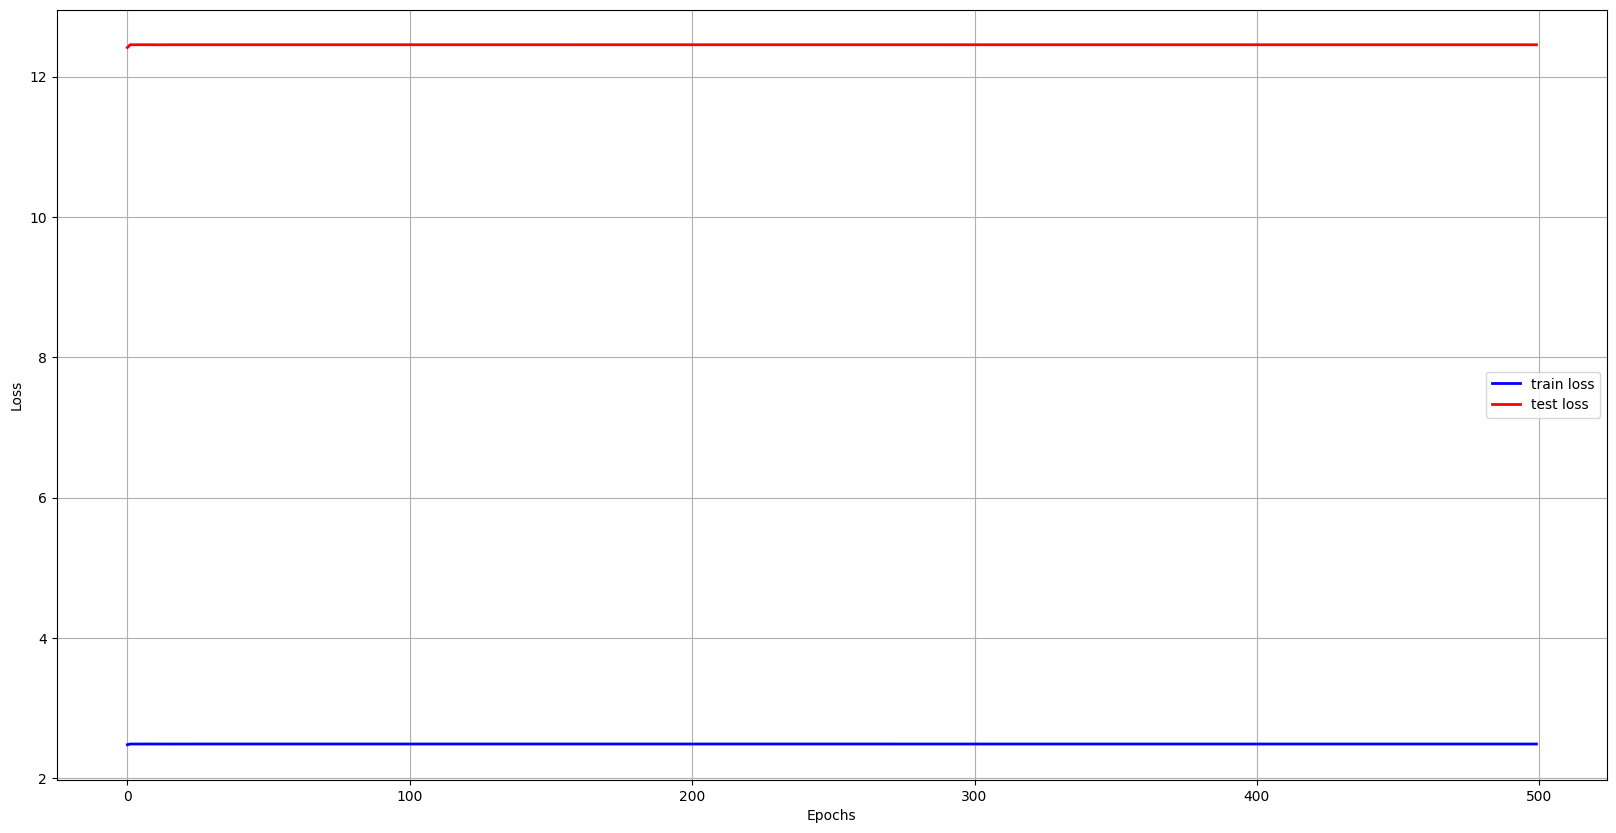

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, label='train loss', color='blue', linewidth=2)
plt.plot(val_loss, label='test loss', color='red', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [25]:
model.eval()

Model(
  (in_fc): Linear(in_features=5, out_features=64, bias=True)
  (hidden_1): Linear(in_features=64, out_features=128, bias=True)
  (hidden_2): Linear(in_features=128, out_features=64, bias=True)
  (out_fc): Linear(in_features=64, out_features=11, bias=True)
  (softmax): Softmax(dim=1)
)

In [26]:
eval_prediction_list = []

for idx, (x, y) in enumerate(test_dataloader):
    x = x.to(device)
    y = y.to(device)
    
    prediction = model(x)
    eval_prediction_list.append(prediction)

y_pred = torch.cat(eval_prediction_list, dim=0)
y_pred = y_pred.detach().cpu().numpy()

In [27]:
print(f"""y_pred Shape: {y_pred.shape}
y_test Shape: {y_test.shape}""")

y_pred Shape: (176, 11)
y_test Shape: (176, 11)


In [28]:
mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

MSE Loss:  0.1714876


In [29]:
y_test_arg = np.argmax(y_test, axis=1)
y_pred_arg = np.argmax(y_pred, axis=1)
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00         7
           6       0.06      1.00      0.11        10
           7       0.00      0.00      0.00        19
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00        36

    accuracy                           0.06       176
   macro avg       0.01      0.09      0.01       176
weighted avg       0.00      0.06      0.01       176



/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


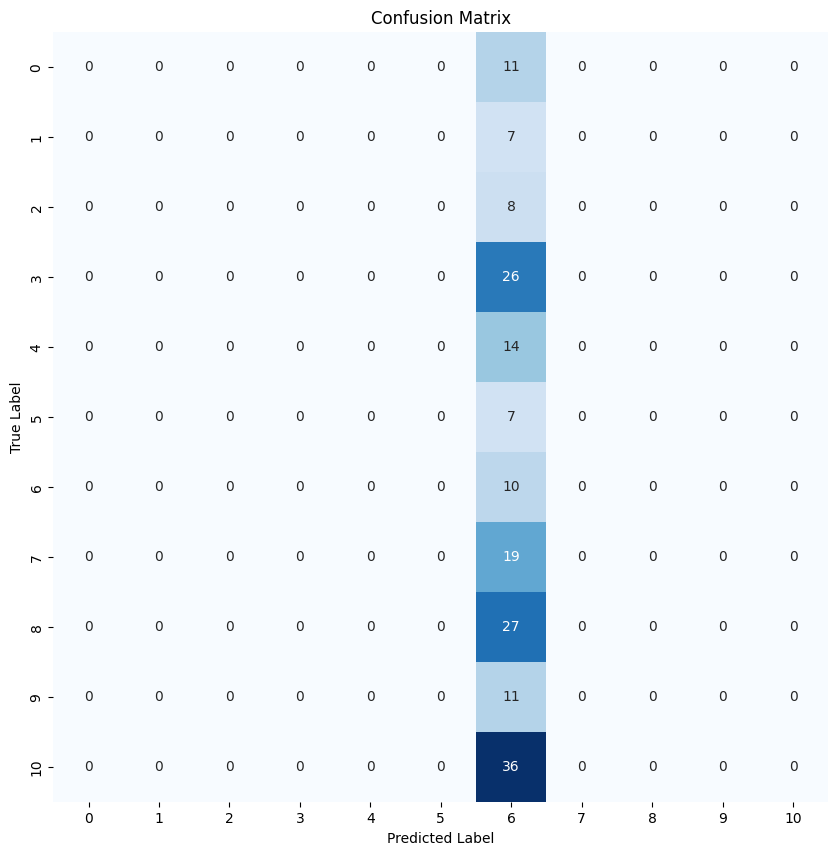

In [30]:
conf_mat = confusion_matrix(y_test_arg, y_pred_arg)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()